In [1]:
import numpy as np
import math
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import io

In [2]:
filename = "breast-cancer-wisconsin.data.txt"
r = io.open(filename, encoding='utf8').readlines()
X = []
Y = []
for i in r:
    x = i.split(',')
    for j in range(1,len(x)-1):
        try:
            x[j] = int(x[j])
        except ValueError:
            x[j] = 0
    X.append(map(int,x[1:len(x)-1]))
    Y.append([int(x[-1])])
Y = np.array(Y)
X = np.array(X)

In [3]:
def find_alpha(class_labels):
    alpha1 = {}
    class_count1 = {}
    for i in class_labels:
        if i[0] not in class_count1.keys():
            class_count1[i[0]] = 1
        else:
            class_count1[i[0]] += 1
    classes1 = class_count1.keys()
    for j in  class_count1:
        alpha1[j] = class_count1[j]*1.0/len(class_labels)
    return classes1,class_count1,alpha1

In [4]:
def segregate_data(data,labels,clabels):
    multi_X = {}
    for i in range(len(clabels)):
        if clabels[i] not in multi_X.keys():
            multi_X[clabels[i]] = []
        for j in range(len(labels)):
            if labels[j][0] == clabels[i]:
                multi_X[clabels[i]].append(data[j]) 
    for i in multi_X:
        multi_X[i] = np.array(multi_X[i])
    return multi_X

In [5]:
def find_mean_multi(data):
    multi_mean1 = {}
    for i in data:
        multi_mean1[i] = np.mean(data[i],axis =0)
    return multi_mean1

In [6]:
def find_covariance_multi(data_split,split_mean,n):
    multi_intrim= {}
    covar = {}
    for i in data_split:
        if i not in multi_intrim.keys():
            multi_intrim[i] = []
        for j in data_split[i]:
            multi_intrim[i].append(j-split_mean[i])
    for i in multi_intrim:
        covar[i] = np.dot(np.array(multi_intrim[i]).transpose(),np.array(multi_intrim[i]))/float(n[i])
    return covar

In [7]:
def training(x,y):
    cl,n,alph = find_alpha(y)
    data_seg = segregate_data(x,y,cl)
    mean_cl = find_mean_multi(data_seg)
    covariance_cl = find_covariance_multi(data_seg,mean_cl,n)
    return alph,mean_cl,covariance_cl

In [8]:
def membership_multi(data,sigma,mean,prior):
    mem = []
    for i in mean:
        det = np.linalg.det(sigma[i])
        y = np.dot((data-mean[i]).transpose(),np.linalg.inv(sigma[i]))
        n= np.dot(y,(data-mean[i]))
        x = math.log(prior[i])-(math.log(det))/float(2)- (n)/float(2)
        mem.append(x)
    return mem

In [9]:
def determinist(data):
    return data.index(max(data))

In [10]:
def find_class(data,clabels):
    return clabels[data]

In [11]:
def prediction(data,sigma,mean,prior,clabels):
    member = []
    for i in data:
        member.append(membership_multi(i,sigma,mean,prior))
    determine =[]
    for j in member:
        determine.append(determinist(j))
    predict = [find_class(i,clabels) for i in determine]
    return predict

In [12]:
def mean_squrae_error(pred,y):
    return sum([(i-j)**2 for i,j in zip(pred,y)])/float(len(pred))

In [13]:
def find_confusion_matrix(clabels,actual,predicted):
    cm= []
    for i in clabels:
        tmp =[0]*len(clabels)
        for j in range(len(actual)):
            if actual[j][0] == i and actual[j][0] == predicted[j]:
                tmp[clabels.index(i)] += 1
            elif actual[j][0] == i and actual[j][0] != predicted[j]:
                tmp[clabels.index(predicted[j])] += 1
        cm.append(tmp)
    return np.array(cm)

In [14]:
def find_accuracy(matrix):
    return np.trace(matrix)*1.0/np.sum(matrix)

In [15]:
def find_precision(matrix):
    pres = []
    x = np.sum(matrix,axis=0)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i == j:
                pres.append(matrix[i][j]*1.0/x[i])
    return pres

In [16]:
def find_recall(matrix):
    rec = []
    x = np.sum(matrix,axis=1)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i == j:
                rec.append(matrix[i][j]*1.0/x[i])
    return rec

In [17]:
def find_fmeasure(prec,rec):
    tmp = []
    for i,j in zip(prec,rec):
        tmp.append(2.0*(i*j)/(i+j))
    return tmp

In [18]:
def roc(clabels,acutal,predicted):
    confmatrix = find_confusion_matrix(clabels,acutal,predicted)
    precision = find_precision(confmatrix)
    recall = find_recall(confmatrix)
    return precision,recall

In [19]:
def cross_validation(data, labels,clabels, n_folds=10,MSE = False):
    cv = KFold(len(labels), n_folds,shuffle= True)
    accuracies = []
    precision_list = []
    recall_list = []
    training_MSE_list =[]
    testing_MSE_list = []
    i = 0
    for train_ind, test_ind in cv: 
        train_alpha,train_mean,train_covar = training(data[train_ind], labels[train_ind])
        training_MSE = mean_squrae_error(prediction(data[train_ind],train_covar,train_mean,train_alpha,clabels), labels[train_ind])
        training_MSE_list.append(training_MSE)
        predict = prediction(data[test_ind],train_covar,train_mean,train_alpha,clabels)
        p,r = roc(clabels,labels[test_ind],predict)
        precision_list.append(p)
        recall_list.append(r)
        testing_MSE_list.append(mean_squrae_error(predict,labels[test_ind]))
        accuracies.append(accuracy_score(labels[test_ind], predict))
        
    if MSE == True:
        for i in range(len(testing_MSE_list)):
            print 'Fold',i,'Testing Error',testing_MSE_list[i]
        print "Average Mean Square Error"
        print "Training Error \t Testing Error"
        print np.mean(training_MSE_list),"\t",np.mean(testing_MSE_list)
    else:
        for i in range(len(accuracies)):
            print 'Fold',i,'Accuracy',accuracies[i]
        print "Average Accuracy ", np.mean(accuracies)
    return precision_list,recall_list

In [20]:
def evaluation(clabels,acutal,predicted):
    confmatrix = find_confusion_matrix(clabels,acutal,predicted)
    print "Confusion Matrix"
    print confmatrix
    accuracy = find_accuracy(confmatrix)
    print "Accuracy", accuracy
    precision = find_precision(confmatrix)
    print "Precision", precision
    recall = find_recall(confmatrix)
    print "Recall", recall
    f_score =find_fmeasure(precision,recall)
    print "F_score", f_score

In [21]:
classes,class_count,alpha = find_alpha(Y)
print "The Classses are", classes
print "The Classes Count ", class_count
print "The prior probabiliy", alpha
multi_X_split =segregate_data(X,Y,classes)

The Classses are [2, 4]
The Classes Count  {2: 458, 4: 241}
The prior probabiliy {2: 0.6552217453505007, 4: 0.3447782546494993}


In [22]:
multi_mean = find_mean_multi(multi_X_split)
multi_covariance = find_covariance_multi(multi_X_split,multi_mean,class_count)
print "Mean for mulivariate features"
for i in multi_mean:
    print i,multi_mean[i]
    print "shape of covariane matrix" , multi_covariance[i].shape

Mean for mulivariate features
2 [ 2.95633188  1.32532751  1.44323144  1.36462882  2.12008734  1.30567686
  2.10043668  1.29039301  1.06331878]
shape of covariane matrix (9, 9)
4 [ 7.19502075  6.57261411  6.56016598  5.54771784  5.29875519  7.56431535
  5.97925311  5.86307054  2.58921162]
shape of covariane matrix (9, 9)


In [23]:
a,m,s = training(X,Y)
predictions = prediction(X,s,m,a,classes)
print "Predicted Value \t True Value "
for i in range(11,21):
    print predictions[i],"\t\t\t",Y[i]

Predicted Value 	 True Value 
2 			[2]
2 			[4]
2 			[2]
4 			[4]
4 			[4]
2 			[2]
2 			[2]
4 			[4]
2 			[2]
4 			[4]


In [24]:
pre_roc, recall_roc = cross_validation(X, Y,classes)

Fold 0 Accuracy 0.928571428571
Fold 1 Accuracy 0.942857142857
Fold 2 Accuracy 0.957142857143
Fold 3 Accuracy 0.942857142857
Fold 4 Accuracy 0.914285714286
Fold 5 Accuracy 0.957142857143
Fold 6 Accuracy 0.957142857143
Fold 7 Accuracy 0.957142857143
Fold 8 Accuracy 1.0
Fold 9 Accuracy 0.95652173913
Average Accuracy  0.951366459627


In [25]:
cross_validation(X, Y, classes,MSE = True)

Fold 0 Testing Error [ 0.11428571]
Fold 1 Testing Error [ 0.05714286]
Fold 2 Testing Error [ 0.17142857]
Fold 3 Testing Error [ 0.28571429]
Fold 4 Testing Error [ 0.4]
Fold 5 Testing Error [ 0.17142857]
Fold 6 Testing Error [ 0.17142857]
Fold 7 Testing Error [ 0.17142857]
Fold 8 Testing Error [ 0.11428571]
Fold 9 Testing Error [ 0.23188406]
Average Mean Square Error
Training Error 	 Testing Error
0.173580639463 	0.188902691511


([[1.0, 0.91666666666666663],
  [1.0, 0.96666666666666667],
  [1.0, 0.88461538461538458],
  [0.95454545454545459, 0.88461538461538458],
  [1.0, 0.78125],
  [0.97826086956521741, 0.91666666666666663],
  [0.97674418604651159, 0.92592592592592593],
  [1.0, 0.88461538461538458],
  [0.97999999999999998, 0.94999999999999996],
  [0.97619047619047616, 0.88888888888888884]],
 [[0.95833333333333337, 1.0],
  [0.97560975609756095, 1.0],
  [0.93617021276595747, 1.0],
  [0.93333333333333335, 0.92000000000000004],
  [0.84444444444444444, 1.0],
  [0.95744680851063835, 0.95652173913043481],
  [0.95454545454545459, 0.96153846153846156],
  [0.93617021276595747, 1.0],
  [0.97999999999999998, 0.94999999999999996],
  [0.93181818181818177, 0.95999999999999996]])

In [26]:
evaluation(classes,Y,predictions)

Confusion Matrix
[[435  23]
 [  6 235]]
Accuracy 0.958512160229
Precision [0.98639455782312924, 0.91085271317829453]
Recall [0.94978165938864634, 0.975103734439834]
F_score [0.96774193548387089, 0.94188376753507008]


In [27]:
print "Precision"
print"Class2 \t\t Class4"
for i in pre_roc:
    print i[0]," \t\t ",i[1]
print "Mean Precision"
print np.mean(pre_roc,axis = 0)

Precision
Class2 		 Class4
0.953488372093  		  0.888888888889
0.973684210526  		  0.90625
1.0  		  0.863636363636
1.0  		  0.851851851852
1.0  		  0.793103448276
0.951219512195  		  0.965517241379
1.0  		  0.888888888889
1.0  		  0.875
1.0  		  1.0
0.97619047619  		  0.925925925926
Mean Precision
[ 0.98545826  0.89590626]


In [28]:
print "Recall"
print"Class2 \t\t Class4"
for i in recall_roc:
    print i[0]," \t\t ",i[1]
print "Mean Recall"
print np.mean(recall_roc,axis = 0)

Recall
Class2 		 Class4
0.931818181818  		  0.923076923077
0.925  		  0.966666666667
0.941176470588  		  1.0
0.914893617021  		  1.0
0.872340425532  		  1.0
0.975  		  0.933333333333
0.934782608696  		  1.0
0.938775510204  		  1.0
1.0  		  1.0
0.953488372093  		  0.961538461538
Mean Recall
[ 0.93872752  0.97846154]


In [29]:
idx = np.argsort(recall_roc,axis = 0)
pre_class1=[]
pre_class2=[]
rec_class1=[]
rec_class2=[]
for i in idx:
    pre_class1.append(pre_roc[i[0]][0])
    pre_class2.append(pre_roc[i[1]][1])
    rec_class1.append(recall_roc[i[0]][0])
    rec_class2.append(recall_roc[i[1]][1])

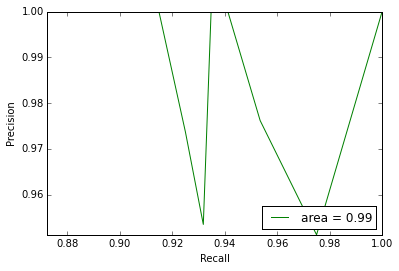

In [30]:
plt.plot(rec_class1,pre_class1,label='area = %0.2f' % np.mean(pre_class1), color="green")
plt.axis([rec_class1[0], rec_class1[len(rec_class1)-1],min(pre_class1),max(pre_class1)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.show()

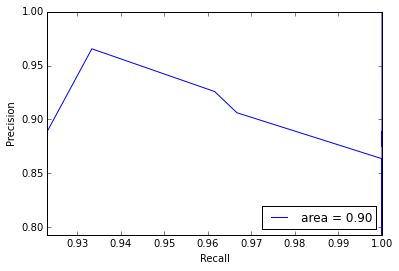

In [31]:
plt.plot(rec_class2,pre_class2,label='area = %0.2f' % np.mean(pre_class2))
plt.axis([rec_class2[0], rec_class2[len(rec_class1)-1],min(pre_class2),max(pre_class2)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.show()

# 3. nD Kclass

In [32]:
filename = "iris.data.txt"
r = io.open(filename, encoding='utf8').readlines()
A = []
B = []
for i in r[0:150]:
    x = i.split(',')
    A.append(map(float,x[0:len(x)-1]))
    if x[-1] == "Iris-setosa\n":
        B.append([1])
    elif x[-1] == 'Iris-versicolor\n':
        B.append([2])
    elif x[-1] == 'Iris-virginica\n':
        B.append([3])
A = np.array(A)
B = np.array(B)

In [33]:
classes_B,class_count_B,alpha_B = find_alpha(B)
print "The Classses are", classes_B
print "The Classes Count ", class_count_B
print "The prior probabiliy", alpha_B
multi_X_splitA =segregate_data(A,B,classes_B)

The Classses are [1, 2, 3]
The Classes Count  {1: 50, 2: 50, 3: 50}
The prior probabiliy {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333}


In [34]:
multi_meanA = find_mean_multi(multi_X_splitA)
multi_covarianceA = find_covariance_multi(multi_X_splitA,multi_meanA,class_count_B)
print "Mean for mulivariate features"
for i in multi_meanA:
    print i,multi_meanA[i]
    print "shape of covariane matrix" , multi_covarianceA[i].shape

Mean for mulivariate features
1 [ 5.006  3.418  1.464  0.244]
shape of covariane matrix (4, 4)
2 [ 5.936  2.77   4.26   1.326]
shape of covariane matrix (4, 4)
3 [ 6.588  2.974  5.552  2.026]
shape of covariane matrix (4, 4)


In [35]:
aA,mA,sA = training(A,B)
predictionsA = prediction(A,sA,mA,aA,classes_B)
print "Predicted Value \t True Value "
for i in range(11,21):
    print predictionsA[i],"\t\t\t",B[i]

Predicted Value 	 True Value 
1 			[1]
1 			[1]
1 			[1]
1 			[1]
1 			[1]
1 			[1]
1 			[1]
1 			[1]
1 			[1]
1 			[1]


In [36]:
cross_validation(A, B,classes_B)

Fold 0 Accuracy 1.0
Fold 1 Accuracy 1.0
Fold 2 Accuracy 0.866666666667
Fold 3 Accuracy 1.0
Fold 4 Accuracy 0.933333333333
Fold 5 Accuracy 1.0
Fold 6 Accuracy 0.933333333333
Fold 7 Accuracy 1.0
Fold 8 Accuracy 1.0
Fold 9 Accuracy 1.0
Average Accuracy  0.973333333333


([[1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 0.66666666666666663, 0.8571428571428571],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 0.83333333333333337],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 0.83333333333333337],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0]],
 [[1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 0.66666666666666663, 0.8571428571428571],
  [1.0, 1.0, 1.0],
  [1.0, 0.80000000000000004, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 0.8571428571428571, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0]])

In [37]:
cross_validation(A, B,classes_B,MSE=True)

Fold 0 Testing Error [ 0.]
Fold 1 Testing Error [ 0.06666667]
Fold 2 Testing Error [ 0.06666667]
Fold 3 Testing Error [ 0.06666667]
Fold 4 Testing Error [ 0.]
Fold 5 Testing Error [ 0.06666667]
Fold 6 Testing Error [ 0.]
Fold 7 Testing Error [ 0.]
Fold 8 Testing Error [ 0.]
Fold 9 Testing Error [ 0.]
Average Mean Square Error
Training Error 	 Testing Error
0.02 	0.0266666666667


([[1.0, 1.0, 1.0],
  [1.0, 1.0, 0.88888888888888884],
  [1.0, 1.0, 0.80000000000000004],
  [1.0, 0.80000000000000004, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 0.83333333333333337],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0]],
 [[1.0, 1.0, 1.0],
  [1.0, 0.75, 1.0],
  [1.0, 0.80000000000000004, 1.0],
  [1.0, 1.0, 0.80000000000000004],
  [1.0, 1.0, 1.0],
  [1.0, 0.8571428571428571, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0]])

In [38]:
evaluation(classes_B,B,predictionsA)

Confusion Matrix
[[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]
Accuracy 0.98
Precision [1.0, 0.97959183673469385, 0.96078431372549022]
Recall [1.0, 0.95999999999999996, 0.97999999999999998]
F_score [1.0, 0.96969696969696972, 0.97029702970297016]
